# Necessary Imports

In [2]:
from arango import ArangoClient
import json
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import folium
import networkx as nx
from wordcloud import WordCloud
from scipy import stats

## Establishing Connection


In [3]:
"""
Establishes a connection to an ArangoDB database and retrieves a list of collections.

This function assumes the `ArangoClient` library is installed and configured 
to connect to your ArangoDB server.

Args:
    hosts (str, optional): A string specifying the ArangoDB server address 
                             (defaults to "http://127.0.0.1:8530").
    username (str, optional): The username for database authentication.
    password (str, optional): The password for database authentication.

Returns:
    tuple: A tuple containing the ArangoDB database connection object and a list 
           of collection names available within the connected database.
"""
ArangoClient = ArangoClient(hosts="http://127.0.0.1:8530")

db = ArangoClient.db("yelp_db", username="super", password="grantaccess")

collections = db.collections()


## Preprocess Json data for easy loading

In [ ]:
"""
Preprocesses JSON data from a file, handling potential errors and writing 
processed data to a new file.

This function reads a file containing JSON objects (one per line) and performs 
basic processing. It attempts to parse each JSON object individually and adds 
successfully parsed objects to a list. Any errors encountered during parsing 
are printed but do not halt the processing of the entire file.

Args:
    input_file (str): The path to the input JSON file.
    output_file (str): The path to the output file where processed data will 
                        be written.
Returns:
    None

Outputs:
    A new file (specified by `output_file`) containing the processed JSON data 
    (one object per line). In case of errors during parsing, informative messages 
    are printed indicating the issue.
"""
def preprocess_json(input_file, output_file):
    with open(input_file, 'r') as f:
        # Read the entire file content
        data = f.read()

        # Split the content by newline character to handle multiple JSON objects
        json_objects = data.strip().split('\n')

    # Process each JSON object separately
    processed_data = []
    for json_str in json_objects:
        try:
            # Load each JSON object separately
            obj = json.loads(json_str)
            processed_data.append(obj)
        except json.JSONDecodeError as e:
            print("Error decoding JSON:", e)

    # Write processed data to the output file
    with open(output_file, 'w') as f:
        json.dump(processed_data, f)

if __name__ == "__main__":
    input_file_list = ["yelp_academic_dataset_business.json", "yelp_academic_dataset_checkin.json", "yelp_academic_dataset_tip.json"]
    output_file_list = ["yelp_academic_dataset_business_updated.json", "yelp_academic_dataset_checkin_updated.json", "yelp_academic_dataset_tip_updated.json"]
    for input_file, output_file in zip(input_file_list, output_file_list):
        preprocess_json(input_file, output_file)


### Creating Collections if they do not exist

In [ ]:
# List of collection names you want to create (if they don't exist)
collection_names = ['business', 'checkin', 'review', 'tip', 'user']

# Create collections if they do not exist
for collection_name in collection_names:
    if not db.has_collection(collection_name):
        db.create_collection(collection_name)

### Inserting data into collections

In [ ]:
"""
Bulk inserts JSON data from files into corresponding ArangoDB collections.

This function iterates through a list of collection names and their corresponding 
JSON file paths. It assumes the JSON files contain processed data (one JSON object 
per line). For each collection-file pair, it reads the JSON data, retrieves the 
collection object from the database, and performs a bulk insert operation using 
'import_bulk'.

Args:
    db (arangodb.Database): An ArangoDB database connection object.
    collection_names (list): A list of ArangoDB collection names.
    file_paths (list): A list of paths to JSON files containing the data to insert.

Returns:
    None

Raises:
    IOError: Any errors encountered while opening or reading the JSON files.
    ArangoDBError: Any errors raised during the bulk insert operation.
"""
collection=["business","checkin","review","tip","user"]
file_list = ["yelp_academic_dataset_business_updated.json", "yelp_academic_dataset_checkin_updated.json", "yelp_academic_dataset_tip_updated.json"]
    
for collection_name, file in zip(collection, file_list):
    collection=db.collection(collection_name)
    json_file = file
    # Read the JSON data from file
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Bulk insert the data into the collection
    collection.import_bulk(data)

- Since the size of the files of user and reviews are very high , we can use aranogosh(arangoimport) to load it entirely
- Command used: arangoimport --file "yelp_academic_dataset_review.json" --type json --collection "review" --server.endpoint "tcp://127.0.0.1:8530" --server.database "yelp_db" --server.username "super" --server.password "grantaccess" --create-collection true --threads 4 

## Defining Edge collection based on uploaded Collection

- There are only two edges in the collection : business_review and user_review

### Creating Edge Collection

In [ ]:
# Define the names of the edge collections
edge_collection_names = ['edge_collection1', 'edge_collection2']

# Create edge collections if they do not exist
for edge_collection_name in edge_collection_names:
    if not db.has_collection(edge_collection_name):
        db.create_collection(edge_collection_name, edge=True)

### Inserting Edges

In [3]:
"""
Inserts a list of edge documents into an ArangoDB edge collection in batches.

This function iterates through a list of edge documents and inserts them into 
the specified ArangoDB edge collection in batches. It uses the `import_bulk` 
method for efficient bulk insertion.
Args:
    collection_name (str): The name of the ArangoDB edge collection to insert data into.
    edge_documents (list): A list of dictionaries representing the edge documents to 
                           be inserted. Each dictionary should have the required 
                           structure for edges in your data model (typically containing 
                           '_from' and '_to' fields).
    batch_size (int, optional): The number of documents to insert in each batch. 
                                Defaults to 1000.
Returns:
    None
    """
# Function to insert records into an edge collection in batches
def insert_edges(collection_name, edge_documents, batch_size=1000):
    for i in range(0, len(edge_documents), batch_size):
        batch = edge_documents[i:i+batch_size]
        db[collection_name].import_bulk(batch)



In [7]:
def process_records_review_business(cursor):
    """
    Processes records from a cursor and prepares edge documents representing 
    relationships between reviews and businesses.

    This function iterates through an ArangoDB cursor containing review data 
    (assumed structure) and generates a list of edge documents. Each edge document 
    represents a relationship between a review and the business it's associated 
    with.

    Args:
        cursor (arangodb.Cursor): An ArangoDB cursor containing review records.

    Returns:
        list: A list of dictionaries representing edge documents. Each dictionary 
              has '_from' and '_to' fields referencing the business and review 
              documents, respectively (assuming '_key' is the document key 
              in the collections).

    Raises:
        KeyError: If a required field (e.g., 'business_id') is missing from a record.
    """
    edge_documents = []
    for record in cursor:
        if record.get('business_id') is None:
            raise KeyError("Missing 'business_id' field in record:", record)
        edge_documents.append({
            "_from": f"business/{record['business_id']}",  # Assuming '_key' is the document key
            "_to": f"review/{record['_key']}"
        })
    return edge_documents
def process_records_review_user(cursor):
    """
    Processes records from a cursor and prepares edge documents representing 
    relationships between reviews and users.

    This function iterates through an ArangoDB cursor containing review data 
    (assumed structure) and generates a list of edge documents. Each edge document 
    represents a relationship between a review and the user who wrote it.

    Args:
        cursor (arangodb.Cursor): An ArangoDB cursor containing review records.

    Returns:
        list: A list of dictionaries representing edge documents. Each dictionary 
              has '_from' and '_to' fields referencing the user and review 
              documents, respectively (assuming '_key' is the document key 
              in the collections).

    Raises:
        KeyError: If a required field (e.g., 'user_id') is missing from a record.
    """
    edge_documents = []
    for record in cursor:
        edge_documents.append({
            "_from":f"user/{record['user_id']}",  # Assuming '_key' is the document key
            "_to": f"review/{record['_key']}"
        })
    return edge_documents

In [9]:
"""
Fetches all reviews from an ArangoDB collection in batches.

This function iteratively retrieves reviews from the specified collection using 
LIMIT and SKIP queries. It accumulates the retrieved documents in a list 
and returns them once all reviews have been fetched.

Args:
    collection (arangodb.Collection): The ArangoDB collection object containing 
                                       the reviews.

Returns:
    list: A list of dictionaries representing the retrieved review documents.

Raises:
    ArangoDBError: Any errors encountered while fetching data from the collection.
"""
reviews_collection = db.collection('review')

# Function to fetch reviews in batches
def fetch_reviews_in_batches(batch_size):
    reviews = []
    offset = 0

    while True:
        # Fetch a batch of reviews using a LIMIT and SKIP
        batch = reviews_collection.all(limit=batch_size, skip=offset)

        if not batch:
            break

        reviews.extend(batch)
        offset += batch_size
    return reviews

# Call the function with your desired batch size
batch_size =50000  # Adjust as needed
reviewsrecords = fetch_reviews_in_batches(batch_size)

In [10]:
"""
Creates edges in an ArangoDB collection to represent relationships between 
reviews and businesses.
"""
edge_documents_review_business = process_records_review_business(reviewsrecords)
insert_edges('business_review', edge_documents_review_business)

In [ ]:
"""
Creates edges in an ArangoDB collection to represent relationships between 
reviews and users.
"""
edge_documents_review_user = process_records_review_user(reviewsrecords)
insert_edges('user_review', edge_documents_review_user)

## Analysis on Data


### Categories of Business and their count

In [3]:
"""
Fetches business categories from a database and stores them in a pandas DataFrame.
The function returns a DataFrame containing a collection named "business" that contains 
documents with a "categories" attribute.

Args:
    None

Returns:
    pandas.DataFrame: A DataFrame containing a single column named "categories" 
    populated with the categories retrieved from the database.

"""
categories=db.aql.execute("FOR b IN business RETURN b.categories")
categories_df = pd.DataFrame(categories, columns=['categories'])
print(categories_df.head())


                                          categories
0  Doctors, Traditional Chinese Medicine, Naturop...
1  Shipping Centers, Local Services, Notaries, Ma...
2  Department Stores, Shopping, Fashion, Home & G...
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...
4                          Brewpubs, Breweries, Food


### Visualize the top categories.

In [4]:
"""
Analyzes business categories in a DataFrame and creates a visualization of the top 20.

This function assumes a DataFrame (`categories_df`) exists with a column named 
"categories" containing comma-separated lists of categories for each business.

Args:
    categories_df (pandas.DataFrame): A DataFrame containing business category information.

Returns:
    None

Outputs:
    A Plotly bar chart displaying the top 20 most frequent business categories.

"""
cat_list = []
for i in categories_df['categories']:
    if i:
        for j in i.split(","):
            cat_list.append(j.strip())
cat_df = pd.DataFrame(cat_list, columns=['categories'])
x = cat_df['categories'].value_counts()

print("There are ", len(x), " different types/categories of Businesses in Yelp!")

# Select the top 20 categories
x = x.sort_values(ascending=False).iloc[:20]

# Define colors for each bar
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff',
          '#00ffff', '#800000', '#008000', '#000080', '#808000']

# Create a Plotly bar chart
fig = go.Figure(data=[
    go.Bar(
        x=x.index,
        y=x.values,
        marker_color=colors
    )
])

fig.update_layout(
    title="What are the top categories?",
    xaxis=dict(title='Category'),
    yaxis=dict(title='# businesses'),
    xaxis_tickangle=-45,
    width=1000,
    height=500
)

fig.show()


There are  1311  different types/categories of Businesses in Yelp!


The graph depicts the top buisness categories in United States,Restaurants being the top and Hotels & Travel being the least.

### Star rating of business

### Analyse the distribution of star rating and create a visualization across all buisness

In [5]:
"""
Analyzes the distribution of star ratings in a DataFrame and creates a visualization.

This function assumes a DataFrame (`star_df`) exists with a column named "stars" 
containing the star rating for each business.

Args:
    star_df (pandas.DataFrame): A DataFrame containing business star rating information.

Returns:
    None

Outputs:
    A Plotly bar chart displaying the distribution of star ratings across all businesses.
"""
# fetch from buiness collection the star rating of each business
star=db.aql.execute("FOR b IN business RETURN b.stars")
star_df = pd.DataFrame(star, columns=['stars'])


# Assuming star_df is your DataFrame containing the 'stars' column
# Replace 'star_df' with the name of your DataFrame if different

# Step 1: Get the value counts of stars
star_counts = star_df['stars'].value_counts().sort_index()

# Step 2: Create the Plotly bar plot
data = [
    go.Bar(
        x=star_counts.index,
        y=star_counts.values,
        marker=dict(color='rgb(158,202,225)')
    )
]

layout = go.Layout(
    title='Distribution of Star Ratings',
    xaxis=dict(title='Stars'),
    yaxis=dict(title='Count'),
    bargap=0.2,
    bargroupgap=0.1
)

fig = go.Figure(data=data, layout=layout)
fig.show()


From the bar graph we can infer that the most common star rating is 4. This helps to understand the distribution of star ratings and how most of the users have rated the business.

### Number of reviews per year

In [6]:
"""
Analyzes review data in a database and visualizes the number of reviews per year.

This function assumes an ArangoDB database connection exists (likely through the 
`db` variable) and a collection named "review" that contains a "date" field for 
each review.

Args:
    None

Returns:
    None

Outputs:
    A Plotly bar chart displaying the number of reviews for each year found in the data.

"""
aql = """
    FOR r IN review
        LET date = DATE_ISO8601(DATE_TIMESTAMP(r.date))
        LET year = DATE_YEAR(date)
        COLLECT review_year = year
        WITH COUNT INTO review_count
        SORT review_year ASC
        RETURN { year: review_year, review_count: review_count }
"""

# Execute the query
cursor = db.aql.execute(aql)

# Prepare data for visualization
data = [(doc['year'], doc['review_count']) for doc in cursor]
years, counts = zip(*data)

# Convert data to DataFrame
df = pd.DataFrame({'Year': years, 'Review_Count': counts})

# Sort DataFrame by Year
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.sort_values(by='Year', inplace=True)

# Create Plotly figure
fig = go.Figure()

# Add bar trace
fig.add_trace(go.Bar(
    x=df['Year'],
    y=df['Review_Count'],
    marker=dict(color=df['Year'].dt.year),
    text=df['Review_Count'],
    textposition='outside',
))

# Update layout
fig.update_layout(
    title='Number of Reviews per Year',
    xaxis_title='Year',
    yaxis_title='Number of Reviews',
    xaxis=dict(tickformat='%Y'),
    yaxis=dict(showgrid=True),
)

# Show plot
fig.show()


Bar chart depicting the number of reviews received by businesses over a specific time period.
The year 2019 recieved the most reviews over the years.

### Fetch the buisness data from the database and display them on a map using name, latitude and longitude.

### Location of businesses on map

In [7]:
"""
Fetches business location data (name, latitude, longitude) from a database and displays them on a map.

This function assumes an ArangoDB database connection exists (likely through the 
`db` variable) and a collection named "business" containing documents with 
"name", "latitude", and "longitude" fields.

Args:
    None

Returns:
    None

Outputs:
    A Folium map displaying markers for up to 500 businesses retrieved from the database.

"""
# Define your AQL query to retrieve latitude, longitude, and business name
aql_query = """
    FOR b IN business
    LIMIT 500
        RETURN { 
            name: b.name,
            latitude: b.latitude,
            longitude: b.longitude
        }
"""

# Execute the AQL query to retrieve business data
cursor = db.aql.execute(aql_query)

# Prepare data for visualization
data = [(doc['name'], doc['latitude'], doc['longitude']) for doc in cursor]
business_names, latitudes, longitudes = zip(*data)

# Create a DataFrame
df = pd.DataFrame({'Business': business_names, 'Latitude': latitudes, 'Longitude': longitudes})

# Create a base map
m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=5)

# Add markers for each business location
for index, row in df.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['Business']).add_to(m)

# Display the map
m


The above map is easy to understand as it shows the location of all the businesses. We can see that location of businesses are mostly in the north america.

### Check-in Data Analysis for year 2019 and 2020 (Covid-19)

In [8]:

"""
Fetches check-in data from a database and converts the 'date' field into a pandas datetime format.

This function assumes an ArangoDB database connection exists (likely through the 
`db` variable) and a collection named "checkin" containing documents with a 'business' 
field and a 'date' field in a compatible format (e.g., 'YYYY, MM, DD').

Args:
    None

Returns:
    pandas.DataFrame: A DataFrame containing check-in data with the 'date' field converted to datetime format.
"""
checkins=db.aql.execute("For c in checkin RETURN c")
checkins_df = pd.DataFrame(checkins, columns=['business','date'])
checkins_df['date'] = checkins_df['date'].apply(lambda x: pd.to_datetime(x.split(', ')))

In [9]:
"""
Prepares check-in data for further analysis by handling potential date lists and sampling specific years.

This function assumes a DataFrame (`checkins_df`) exists containing check-in data 
(likely with a 'date' column). It also assumes the 'date' field might contain 
lists or arrays of dates for each check-in (applicable if the `.explode()` 
method is used).

Args:
    checkins_df (pandas.DataFrame): A DataFrame containing check-in data.

Returns:
    tuple: A tuple containing two DataFrames, one for check-in dates from year 2019 
           (sampled to 50000 entries) and another for check-in dates from year 2020 
           (also sampled to 50000 entries).

"""
dates = checkins_df['date'].explode()
# Sample data for the years 2019 and 2020
data_2019 = dates[dates.dt.year == 2019].sample(n=50000)
data_2020 = dates[dates.dt.year == 2020].sample(n=50000)



In [10]:
"""
Visualizes the distribution of check-in dates using a Plotly histogram.

This function assumes a DataFrame (`sampled_dates`) exists containing check-in dates 
(likely as a datetime or similar format).

Args:
    sampled_dates (pandas.DataFrame): A DataFrame containing a column representing check-in dates.

Returns:
    None

Outputs:
    A Plotly histogram displaying the distribution of check-in dates.
"""
sampled_dates = pd.concat([data_2019, data_2020])

# Create histogram data
hist_data = go.Histogram(x=sampled_dates, marker_color='blue', opacity=0.7)

# Create layout
layout = go.Layout(title='Check-ins Distribution',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Count'),
                   bargap=0.05)

# Create figure
fig = go.Figure(data=[hist_data], layout=layout)

# Show the plot
fig.show()



From the graph we can infer that the Number of Check-ins in early 2020 is higher than in 2019 but significantly drops due to the Covid-19 Pandemic.

7. Visualize the connection between a buisness and its associated reviews.

In [11]:
"""
Visualizes connections between a business and its associated reviews using a Plotly graph.

This function assumes an ArangoDB database connection exists (likely through the 
`db` variable) and collections named "business" and "business_review". The 
"business_review" collection is assumed to have edges connecting businesses to 
reviews.

Args:
    business_key (str): The unique identifier (key) of the business to analyze.

Returns:
    None

Outputs:
    A Plotly graph depicting connections between the specified business and reviews 
    found within 3 levels of traversal.
"""
# Define the AQL query
aql_query = """
LET businessKey = @businessKey
FOR v, e, p IN 1..3 OUTBOUND CONCAT('business/', @businessKey) business_review
RETURN v
"""

# Execute the AQL query
cursor = db.aql.execute(aql_query, bind_vars={'businessKey': 'tUFrWirKiKi_TAnsVWINQQ'})

# Initialize a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for document in cursor:
    review_id = document['_key']
    G.add_node(review_id)
    G.add_edge('business', review_id)

# Compute layout
pos = nx.spring_layout(G)

# Create a Plotly figure
fig = go.Figure()

# Add nodes to the figure
for node in G.nodes:
    fig.add_trace(go.Scatter(x=[pos[node][0]], y=[pos[node][1]], mode='markers', marker=dict(size=20, color='blue'), text=node))

# Add edges to the figure
for edge in G.edges:
    fig.add_trace(go.Scatter(x=[pos[edge[0]][0], pos[edge[1]][0]], y=[pos[edge[0]][1], pos[edge[1]][1]], mode='lines', line=dict(color='gray', width=1)))

# Update layout
fig.update_layout(title="Business-Review Visualization", showlegend=False, hovermode='closest', xaxis=dict(visible=False), yaxis=dict(visible=False))

# Show plot
fig.show()


A directed graph object (G) is created using the NetworkX library. This graph represents the connections between the business (tUFrWirKiKi_TAnsVWINQQ) and the retrieved reviews.
The code iterates through each document (review) and adds it as a node to the graph.
An edge is added between the business node and each review node.

### Top Ten users in yelp

In [17]:
"""
Fetches reviews from an ArangoDB database collection in batches and analyzes 
user review activity.

This function efficiently retrieves reviews using batch processing to handle 
large datasets without overwhelming database resources. It then analyzes 
the reviews for each user, calculating various statistics.

Args:
    db (arango.Database): An ArangoDB database connection object.

Returns:
    pandas.DataFrame: A DataFrame containing user-based review statistics, 
                      including review count, date range of activity, engagement 
                      metrics ("useful", "funny", "cool" marks), and average rating.

Raises:
    Exception: If an error occurs while interacting with the ArangoDB database.
"""
reviews_collection = db.collection('review')

# Function to fetch reviews in batches
def fetch_reviews_in_batches(batch_size):
    reviews = []
    offset = 0

    while True:
        # Fetch a batch of reviews using a LIMIT and SKIP
        batch = reviews_collection.all(limit=batch_size, skip=offset)

        if not batch:
            break

        reviews.extend(batch)
        offset += batch_size
    return reviews

# Call the function with your desired batch size
batch_size = 75000  # Adjust as needed
reviews = fetch_reviews_in_batches(batch_size)
reviews=pd.DataFrame(reviews,columns=['review_id','user_id','business_id','stars','useful','funny','cool','text','date'])
user_agg=reviews.groupby('user_id').agg({'review_id':['count'],'date':['min','max'],
                                'useful':['sum'],'funny':['sum'],'cool':['sum'],
                               'stars':['mean']})
user_agg=user_agg.sort_values([('review_id','count')],ascending=False)
user_agg.head(10)

review_id                 date                       \
                           count                  min                  max   
user_id                                                                      
_BcWyKQL16ndpBdggh2kNA      3048  2008-05-29 15:15:17  2021-12-27 23:37:25   
Xw7ZjaGfr0WNVt6s_5KZfA      1840  2011-01-12 05:20:51  2021-12-27 19:53:28   
0Igx-a1wAstiBDerGxXk2A      1747  2009-01-14 19:55:01  2022-01-18 18:07:57   
-G7Zkl1wIWBBmD0KRy_sCw      1682  2012-12-22 21:01:00  2022-01-16 23:14:31   
ET8n-r7glWYqZhuR6GcdNw      1653  2008-03-28 15:57:05  2021-04-21 13:55:40   
bYENop4BuQepBjM1-BI3fA      1578  2010-08-08 15:56:31  2022-01-13 17:24:20   
1HM81n6n4iPIFU5d2Lokhw      1554  2011-07-28 15:42:13  2022-01-17 19:34:29   
fr1Hz2acAb3OaL3l6DyKNg      1447  2014-05-10 14:24:26  2022-01-16 12:14:05   
wXdbkFZsfDR7utJvbWElyA      1396  2016-06-11 02:18:44  2021-12-08 10:24:16   
Um5bfs5DH6eizgjH3xZsvg      1391  2011-12-25 08:29:48  2022-01-01 20:07:00   

                         useful    funny     cool     stars  
                            sum      sum      sum      mean  
user_id                                                      
_BcWyKQL16ndpBdggh2kNA  11043.0   3344.0   6373.0  3.637795  
Xw7ZjaGfr0WNVt6s_5KZfA  12011.0   5034.0   7225.0  4.072826  
0Igx-a1wAstiBDerGxXk2A   8254.0   3169.0   5022.0  3.990269  
-G7Zkl1wIWBBmD0KRy_sCw  34694.0  17774.0  26749.0  3.652794  
ET8n-r7glWYqZhuR6GcdNw  19474.0   5631.0  12585.0  4.046582  
bYENop4BuQepBjM1-BI3fA  11680.0   4168.0   8600.0  3.853612  
1HM81n6n4iPIFU5d2Lokhw   6138.0   2241.0   3198.0  3.045045  
fr1Hz2acAb3OaL3l6DyKNg  15356.0   4634.0  13145.0  3.946786  
wXdbkFZsfDR7utJvbWElyA   5715.0    418.0   3057.0  4.210602  
Um5bfs5DH6eizgjH3xZsvg   4645.0   1975.0   3424.0  3.804457

This code fetches the reviews by top ten user and the aggregated statistics for each user. The first user has the most reviews count and the last user has the least reviews count in the dataframe.

### Sentiment Analysis

In [10]:
"""
Calculates the sentiment score of a given text using the VADER model.

This function utilizes the previously initialized VADER sentiment analyzer 
(sid) to analyze the provided text and extract its compound sentiment score.
The compound score ranges from -1 (strongly negative) to +1 (strongly positive)
with 0 indicating neutrality.

Args:
    text (str): The text for which sentiment analysis is to be performed.

Returns:
    float: The sentiment score of the text, ranging from -1 (negative) to +1 (positive).
"""
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)['compound']

# Apply sentiment analysis to the first 5000 records in the 'text' column
reviews['sentiment_score'] = reviews['text'].iloc[:5000].apply(get_sentiment_score)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
reviews[['stars','text','sentiment_score']].head(100)

stars                                               text  sentiment_score
0     3.0  If you decide to eat here, just be aware it is...           0.8597
1     5.0  I've taken a lot of spin classes over the year...           0.9858
2     3.0  Family diner. Had the buffet. Eclectic assortm...           0.9201
3     5.0  Wow!  Yummy, different,  delicious.   Our favo...           0.9588
4     4.0  Cute interior and owner (?) gave us tour of up...           0.9804
..    ...                                                ...              ...
95    5.0  Had to wait until my third trip to NOLA to act...           0.9875
96    5.0  A GREAT EXPERIENCE!!!!!!!!!  I was a completel...           0.9344
97    5.0  Wow! I never thought my sons phone could be re...           0.9308
98    1.0  Service and management terrible... After messi...          -0.8519
99    4.0  I have been to a number of dog friendly hotels...           0.9911

[100 rows x 3 columns]

Sentiment analysis is applied to a subset of the review data (first 5000 records) in the text column of the reviews DataFrame.
The apply method with the get_sentiment_score function iterates through each text string in the text column (limited to the first 5000 rows) and calculates its sentiment score.
The calculated scores are stored in a new column named sentiment_score within the reviews DataFrame.

We can see from the above dataframe the star rating corresponds to the sentinment score as 1 stars have negative sentiment score and 5 stars have positive sentiment score.

### Wordcloud Visualization

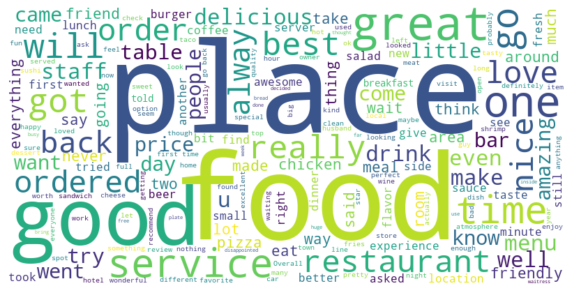

In [24]:
"""
Generates a word cloud visualization based on the most frequent words 
appearing in the first 5000 review texts.

This function analyzes a subset of the 'text' column in the 'reviews' DataFrame 
to create a word cloud. The word cloud visually represents the most frequent 
words found within the reviews, with larger font sizes indicating higher frequency.

Args:
    reviews (pandas.DataFrame): A DataFrame containing user review data, including 
                                a 'text' column with review content.

Returns:
    None

Outputs:
    A matplotlib plot displaying the generated word cloud visualization.

"""
# Concatenate all review text into a single string
all_text = ' '.join(reviews['text'].iloc[:5000])  # Concatenating only the first 5000 reviews

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Generates a word cloud visualization based on the most frequent words appearing in the first 5000 review texts.
This function analyzes only the first 5000 reviews in the 'text' column. 

From the small sample we can find that the words place , food , good and service are the most used words in the reviews.

### Business with most Five Star Reviews from Users

In [37]:
"""
Identifies the business with the highest number of 5-star reviews in the dataset.

This function analyzes the 'reviews' DataFrame to find which business has received 
the most positive feedback (highest count of 5-star reviews).

Args:
    reviews (pandas.DataFrame): A DataFrame containing user review data, including 
                                a 'stars' column indicating review ratings 
                                (potentially numerical) and a 'business_id' column 
                                linking reviews to businesses.

Returns:
    None

Outputs:
    Prints the name of the business that has received the most 5-star reviews.

Notes:
    - Assumes the 'stars' column in the 'reviews' DataFrame contains numerical 
      ratings, with 5 representing the highest rating (positive feedback).
    - This code retrieves business name using an ArangoDB AQL query. Modify 
      the query and database interaction logic if your data structure or access method differs.
"""

five_star_reviews_df = reviews[reviews['stars'] == 5]

# Group by business_id and count the number of 5-star reviews for each business
business_five_star_counts = five_star_reviews_df.groupby('business_id').size()

# Find the business with the highest count of 5-star reviews
business_with_most_five_stars = business_five_star_counts.idxmax()

# Get the count of 5-star reviews for the business with the most
most_five_star_count = business_five_star_counts.max()

# Fetch the name of the business with the most 5-star reviews
aql_query = f"""
FOR b IN business
FILTER b.business_id == '{business_with_most_five_stars}'
RETURN b.name
"""
cursor = db.aql.execute(aql_query)

for doc in cursor:
    print("The business with most 5 star reviews is:", doc)

The business with most 5 star reviews is: Reading Terminal Market


This code iterates through the database and finds the buisness with most 5 star reviewa and the prints it.In this case it is Reading Terminal Market.


In [59]:
"""
Analyzes and visualizes rating trends across years for the business 
with the most 5-star reviews.

This function focuses on the business identified as having the highest 
count of 5-star reviews and explores its historical rating patterns.

Args:
    reviews (pandas.DataFrame): A DataFrame containing user review data, including 
                                a 'stars' column indicating review ratings 
                                (potentially numerical) and a 'business_id' column 
                                linking reviews to businesses.
    business_with_most_five_stars (str): The business ID of the business that 
                                       received the most 5-star reviews (obtained 
                                       from previous analysis).

Returns:
    None

Outputs:
    A Plotly figure displaying the count of each rating (1 to 5 stars) 
    across years for the specified business.

Notes:
    - Assumes the 'stars' column in the 'reviews' DataFrame contains numerical 
      ratings (1 to 5) and 'date' represents the review date.
    - This code utilizes Plotly for visualization. You can modify it if you prefer 
      a different plotting library.
"""
business_reviews = reviews[reviews['business_id'] == business_with_most_five_stars]

# Step 2: Extract the year from the 'date' column and count the occurrences of each rating for each year
business_reviews['year'] = pd.to_datetime(business_reviews['date']).dt.year
rating_counts_by_year = business_reviews.groupby(['year', 'stars']).size().reset_index(name='count')

# Step 3: Plot the count of each rating across years using Plotly
fig = px.line(rating_counts_by_year, x='year', y='count', color='stars',
              title='Count of Each Rating Across Years for the Business with Most 5-Star Reviews',
              labels={'year': 'Year', 'count': 'Count', 'stars': 'Star Rating'},
              line_shape='spline')  # Smooth line shape

fig.update_traces(mode='markers+lines', marker=dict(size=8))
fig.show()


C:\Users\visha\AppData\Local\Temp/ipykernel_21268/1510555500.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



This code provides a graphical representation for count of each rating (1 to 5 stars) across years for the specified business.
From the graph we can interpret that the business Reading Terminal Market has started to receive many 5 star reviews from the year 2012 and was having it around 2018 but siginificantly started dropping in 2020 (Covid Times).

### Top 10 Cities with most businesses in Yelp

In [42]:
"""
Analyzes and visualizes rating trends across years for a specified business.

This function extracts year information from the 'date' column in a DataFrame 
containing user reviews and calculates the frequency of each rating (1 to 5 stars) 
for each year associated with the business. It then creates a Plotly visualization 
to display these trends.

Args:
    reviews (pandas.DataFrame): A DataFrame containing user review data, including 
                                a 'stars' column indicating review ratings 
                                (potentially numerical) and a 'date' column 
                                representing the review date.
    business_id (str): The business ID of the business for which to analyze rating trends.

Returns:
    None

Outputs:
    A Plotly figure displaying the count of each rating (1 to 5 stars) across years 
    for the specified business.

Notes:
    - Assumes the 'stars' column in the 'reviews' DataFrame contains numerical 
      ratings (1 to 5) and the 'date' column represents the review date.
    - This code utilizes Plotly for visualization. You can modify it if you prefer 
      a different plotting library.

"""
aql_query = """
LET businesses = (
    FOR b IN business
        COLLECT city = b.city WITH COUNT INTO count
        RETURN { city, count }
)
LET sortedCities = (
    FOR b IN businesses
        SORT b.count DESC
        RETURN b
)
RETURN sortedCities
"""
cities=db.aql.execute(aql_query)

for city in cities:
    cities_df = pd.DataFrame(city)

In [56]:
"""

Args:
    cities_df (pandas.DataFrame): A DataFrame containing city data, including 
                                  a 'city' column with city names and a 'count' 
                                  column representing the number of businesses 
                                  in each city.

Returns:
    None

Outputs:
    A Plotly figure displaying a horizontal bar chart with the top 10 cities 
    on the y-axis and their corresponding business counts on the x-axis.
"""
top_10_cities = cities_df.head(10)

city=list(top_10_cities['city'])
city.reverse()

count=list(top_10_cities['count'])
count.reverse()

data = [go.Bar(y=city, x=count, orientation='h')]

# Define layout
layout = go.Layout(title="Top 10 Cities by Business Count",
                   xaxis=dict(title="Count"),
                   yaxis=dict(title="City"),
                   margin=dict(l=150),  # Adjust left margin for longer city names
                   height=600)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Show plot
fig.show()



From the graph we can interpret that the top 10 cities with the most businesses are Philadelphia, Tucson, Tampa , Indianpolis , Nashville,etc in the respective order


### Which users have reviewed the most diverse set of businesses?

In [60]:
"""
Args:
    db (arango.Database): An ArangoDB database connection object.

Returns:
    pandas.DataFrame: A DataFrame containing user IDs and their corresponding 
                      diverse review counts (potentially indicating users who have 
                      reviewed a wider variety of businesses or categories).

Notes:
    - Assumes the "user_review" collection edges connect users and reviews.
    - The `user_id` is extracted by assuming a specific document structure 
      (user ID prefixed with "user/"). Modify the query logic if your data structure differs.
    - "Diverse review count" in this context refers to the total number of reviews 
      written by a user, potentially implying a wider range of reviewed entities.

"""
aql_query = """
FOR user_review_edge IN user_review
    COLLECT user_id = SUBSTRING(user_review_edge._from, LENGTH("user/") + 1) WITH COUNT INTO review_count
    SORT review_count DESC
    LIMIT 5
    RETURN { user_id: user_id, diverse_review_count: review_count }
    """

user_review_df = pd.DataFrame(db.aql.execute(aql_query), columns=['user_id', 'diverse_review_count'])
user_review_df

user_id  diverse_review_count
0  BcWyKQL16ndpBdggh2kNA                  3048
1  w7ZjaGfr0WNVt6s_5KZfA                  1840
2  Igx-a1wAstiBDerGxXk2A                  1747
3  G7Zkl1wIWBBmD0KRy_sCw                  1682
4  T8n-r7glWYqZhuR6GcdNw                  1653

We can see that the top 5 users who have reviewed the most diverse set of businesses are the users above with the highest diverse review count of 3048 , 1840 , 1747 , 1682 , 1653 respectively.


### What is the correlation between the length of a review and its rating?

In [61]:
"""
Classifies reviews into positive, negative, or neutral categories based on sentiment 
analysis scores and predefined sentiment thresholds.


Args:
    reviews_df (pandas.DataFrame): A DataFrame containing user review data, including 
                                  a 'text' column with review content and a 
                                  'sentiment_score' column representing the 
                                  sentiment analysis score for each review 
                                  (potentially ranging from -1 to +1).
    positive_threshold (float): The minimum sentiment score to categorize a review as positive.
    negative_threshold (float): The maximum sentiment score to categorize a review as negative.

Returns:
    pandas.DataFrame: A DataFrame with an additional column named 'sentiment' 
                      indicating the sentiment category ('positive', 'negative', 
                      or 'neutral') for each review.

Notes:
    - Assumes the 'sentiment_score' column exists in the DataFrame and represents 
      sentiment analysis scores (likely between -1 and +1).
    - This code uses pre-defined thresholds to classify sentiment. Consider 
      experimenting with different thresholds based on your specific data and desired 
      classification granularity.
"""
aql_query = """
FOR review IN review
    LET review_length = LENGTH(review.text)
    RETURN { review_length: review_length, rating: review.stars }
    """

review_length_df = pd.DataFrame(db.aql.execute(aql_query), columns=['review_length', 'rating'])

# Calculate correlation
correlation = review_length_df['review_length'].corr(review_length_df['rating'])

print("Correlation between review length and rating:", correlation)


Correlation between review length and rating: -0.19157250230654174



The correlation coefficient you obtained, -0.1915725, indicates a weak negative correlation between review length and rating meaning there is no significant relationship between the two variables. 

### Find user who have the highest number of fans:

In [74]:
"""
Args:
    db (arango.Database): An ArangoDB database connection object.

Returns:
    list: A list of dictionaries, each representing a user document with the maximum fan count.

Notes:
    - Assumes the "user" collection contains documents with a "fans" field representing 
      the number of fans for each user.
    - This code retrieves all users with the maximum fan count. Consider modifying the 
      query to retrieve only the first user or a limited number if there are many users 
      with the same maximum fan count.

"""
aql_query = """
    LET max_fans = MAX(
        FOR user IN user 
        RETURN user.fans
    )
    FOR user IN user
    FILTER user.fans == max_fans
    RETURN user
"""

# Execute the AQL query
cursor = db.aql.execute(aql_query)

# Fetch the results
users_with_max_fans = [document for document in cursor]

# Print the results
print(users_with_max_fans)

[{'_key': '1674023', '_id': 'user/1674023', '_rev': '_hpUVJ4a--c', 'user_id': '37cpUoM8hlkSQfReIEBd-Q', 'name': 'Mike', 'review_count': 1882, 'yelping_since': '2009-04-25 14:54:26', 'useful': 22860, 'funny': 10965, 'cool': 15350, 'elite': '2012,2013,2014,2015,2016,2017,2018,2019,20,20,2021', 'friends': 'fLRfYMFIRzjX28OFTsCu4g, pEIzH_tNwK7pcqTViKm-RQ, NvUeb5G_mSSxgKhEE_Hueg, deaELkn3M_4pq_OAYvw_Ig, HKNvEk6G7ZcT68Be-EMQ9g, dOFyIGbyfB69VB4pnoKqQA, WG3w_73scm_JUWJ_3Lgn0Q, _SXFvZW1f7IAia7I4WlQFw, oTsrQ4r4FZuYAyB58xypzw, TM9NWmEEEvG2ZV4-UQ3UbA, 40KfMMPq7L3EGReF9x-wLA, ITa3vh5ERI90G_WP4SmGUQ, Zrz0DKRSACSVxiGPJruDcA, Dix9X_ocFsp-j1R5p2K-_Q, DhpKrO3XOfrpew1JcetHMA, y8eBNwZy-bDxAlMxc2t7FQ, IprKHet03baoU8heBOYuwQ, q01khtt3I3bWBvHGxwA6vA, ytWFR6cNNhKYVlFdQjkOww, NiHToxa8Fzx5yM1NYAEgaw, dlSaAO17A2dsu0qdhJLFcg, 4K1LFL0t0TAHRUxbfoEdew, zPi0yIaS57RNf-dDJdWWkg, hLVtw8BCQMrsra6_THVSbQ, VgHgDLkuIFTnbqOcz2s7Mg, x0KsUGST3w8fzYyQQ81FAw, HpJzEFN1kyuH6VAF_usqKg, Wh-PbbdbeYlyOGumxTwFJg, bwUb11KNZkFMEW1HhMjSvA,

Identifies and retrieves users with the highest number of fans in an ArangoDB collection.This function utilizes an ArangoDB AQL query to find users with the maximum number of fans stored in the "user" collection. It employs a two-step approach:

1. The query first calculates the maximum fan count across all users.
2. It then filters the "user" collection to retrieve only users whose fan count matches the previously determined maximum.

### What is the distribution of users across fan counts range?

In [75]:
"""
Analyzes and visualizes the distribution of users across fan count ranges using an ArangoDB AQL query.

This function categorizes users based on their fan counts and displays the distribution 
visually. It utilizes an ArangoDB AQL query to retrieve fan counts for all users 
in the "user" collection. Then, it defines pre-determined fan count ranges and iterates 
through the retrieved fan counts, incrementing counters for each range the fan count falls within.

Args:
    db (arango.Database): An ArangoDB database connection object.
    fan_ranges (list of tuples): A list of tuples representing user fan count ranges. 
                                 Each tuple is (lower_bound, upper_bound).

Returns:
    None

Outputs:
    A Plotly pie chart visualizing the distribution of users across the defined fan count ranges.

"""
# Define fan count ranges
fan_ranges = [(0, 100), (101, 500), (501, 1000), (1001, 5000), (5001, float('inf'))]

# Fetch data for fan counts of users
aql_query = """
    FOR user IN user
        LET fan_count = user.fans
        RETURN fan_count
"""
cursor = db.aql.execute(aql_query)

# Initialize counters for each fan count range
fan_count_ranges = {range_: 0 for range_ in fan_ranges}

# Iterate over fan counts and increment counters for respective ranges
for fan_count in cursor:
    for range_ in fan_ranges:
        if range_[0] <= fan_count <= range_[1]:
            fan_count_ranges[range_] += 1
            break

# Prepare data for visualization
labels = [f'{range_[0]} - {range_[1]}' if range_[1] != float('inf') else f'{range_[0]}+' for range_ in fan_ranges]
fan_counts = list(fan_count_ranges.values())

# Create pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=fan_counts)])
fig.update_layout(title='Distribution of Users by Fan Count Ranges')
fig.show()

From the graph we can interpret that the majority of users have a fan count between 0 and 100. 

### Are businesses with a higher star rating significantly more likely to receive useful votes on their reviews compared to businesses with lower star ratings? (T-test)

In [10]:
"""
Analyzes the relationship between star ratings and user-perceived review usefulness using an ArangoDB AQL query and t-test.

This function investigates whether there's a statistically significant difference 
in the perceived usefulness (measured by "useful" votes) of reviews for businesses 
with high versus low star ratings.

Args:
    db (arango.Database): An ArangoDB database connection object.

Returns:
    None

Outputs:
    Prints the results of an independent samples t-test, including the t-statistic, 
    p-value, and an interpretation based on a pre-defined significance level (alpha).


"""
# Fetch data for star ratings and useful votes from the edge collection
aql_query = """
    FOR edge IN business_review
        LET business = DOCUMENT(CONCAT('business/', edge._from))
        LET review = DOCUMENT(CONCAT('review/', edge._to))
        LIMIT 200000
        RETURN { "stars": business.stars, "useful": review.useful }
"""
cursor = db.aql.execute(aql_query)

# Extract data for analysis
star_ratings = []
useful_votes = []
for doc in cursor:
    star_ratings.append(doc["stars"])
    useful_votes.append(doc["useful"])

# Split the data into two groups based on star ratings (e.g., high and low star ratings)
high_star_ratings = [useful_votes[i] for i in range(len(star_ratings)) if star_ratings[i] >= 4]
low_star_ratings = [useful_votes[i] for i in range(len(star_ratings)) if star_ratings[i] < 4]

# Perform independent samples t-test
t_statistic, p_value = stats.ttest_ind(high_star_ratings, low_star_ratings)

# Print the results
print("Independent Samples t-test Results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("There is a significant difference in the mean number of useful votes between businesses with higher and lower star ratings.")
else:
    print("There is no significant difference in the mean number of useful votes between businesses with higher and lower star ratings.")

Independent Samples t-test Results:
t-statistic: -16.142516639777856
p-value: 1.3964304137868268e-58
There is a significant difference in the mean number of useful votes between businesses with higher and lower star ratings.


The code provides evidence suggesting a connection between higher star ratings and user perception of review usefulness.
t-statistic: -16.1425: This is a very large negative value, suggesting a strong tendency for reviews of businesses with higher star ratings to have a higher average number of useful votes.
p-value:1.39643e-58: This is an extremely small p-value, which is statistically significant. It implies that the observed difference in useful votes between high and low star ratings is very unlikely to be due to random chance.

 Based on these results, we can conclude with a high degree of confidence (considering the chosen significance level of 0.05) that there's a real difference in how users perceive the usefulness of reviews for businesses with higher versus lower star ratings. Reviews for businesses with higher star ratings tend to be considered more useful by users, on average.

